# Lecture 20: Black-box optimization and applications

[EE227C course page](https://ee227c.github.io/)  
[Download ipynb file](https://ee227c.github.io/code/lecture19.ipynb)

In this lecture, we'll look at the well known EM algorithm and alternating minimization for solving non-convex optimization problems.

Overview:

* [Black-box optimization](#zero)
 * [Random search](#random)
 * [Nelder-Mead](#nm)
* [Reinforcement learning](#rl)
 * [Flappy bird](#floppy)
 * [Learning policies](#learning)
 * [Policy gradient](#policy)

Acknowledgements: Many thanks to Ben Recht for suggestions based on his recent [blog post series](http://www.argmin.net/2018/03/20/outsider-rl/). The second part of this lecture is mostly copied either verbatim or with small edits from his blog posts.

In [1]:
%matplotlib inline

import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from plotters import error_plot, kwargs, setup_layout

np.random.seed(1)
setup_layout()

<a name="zero"></a>

## Black-box optimization

In this lecture we will study what is known as *black-box* optimization, *derivative-free* optimization, or *zeroth-order* optimization.

Here, the general goal is to solve a problem

$$
\min_{x} f(x),
$$

possibly over a constraint set $x\in\Omega,$ where we do not have access to the gradients of the function $f\colon\mathbb{R}^n\to\mathbb{R}$. Rather we can only query points $x\in\Omega$ and receive the function evaluation $f(x)\in\mathbb{R}.$

<a name="random"></a>

### Basic random search

**Random search**

Pick an initial point $x_0$

Iterate from $t=1$:
* Pick $d_t$ be a random direction in $\mathbb{R}^n.$ 
* Set $\eta^* = \arg\min_\eta f(x_t+\eta d_t)$
* Put $x_t = x_{t-1} + \eta^* d_t$

#### Analysis

We'll see that essentially whatever was true for gradient descent is also true for this algorithm at the cost of a factor $n$ in the number of iterations. To see the idea, assume that $f$ is a $\beta$-smooth convex, differentiable function.

For any $\eta,$ by Taylor's theorem and smoothness, we have:

$$
f(x_t + \eta d_t) \le f(x_t) + \eta \langle d_t, \nabla f(x_t) \rangle + \frac{\eta^2\beta}{2}\|d_t\|^2
$$

And hence, minimizing the upper bound, there is a step size $\eta$ for which we have

$$
f(x_t + \eta d_t) \le f(x_t) - \frac{1}{\beta}\langle d_t, \nabla f(x_t)\rangle^2 \|d_t\|^2
$$

Moreover, the step size we actually took can only be better:

$$
f(x_t + \eta^* d_t)  \le f(x_t + \eta d_t).
$$

Taking expectations then shows

$$
\mathbb{E}[f(x_t + \eta^* d_t)]
\le \mathbb{E}[f(x_t)] - \frac1{\beta n}\mathbb{E}[\|\nabla f(x_t)\|^2]
$$

This looks just like what we know for gradient descent with an extra factor of $n$.  Now we can use whatever assumptions we want: 
* For convex functions, we get a rate of $nL/\epsilon$. 
* For strongly convex, you get $nL\log(1/\epsilon)$.
* For non-convex functions, we converge to a stationary point.

Basically, it's $n$ times the complexity of the gradient method on the function class.

#### Line search subproblem

As stated the algorithm uses an optimal step size in a random direction. We can generally only approximate this step in various ways. We'll discuss what's known as **Golden-Section Search**:


In [2]:
# Source: https://en.wikipedia.org/wiki/Golden-section_search

def gss(f, a, b, tol=1e-5):
    """Golden section search
    
    Find the minimum of f on [a,b]
    f: a strictly unimodal function on [a,b]
    """
    gr = (np.sqrt(5) + 1) / 2
    c = b - (b - a) / gr
    d = a + (b - a) / gr 
    while abs(c - d) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c
        # we recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr
    return (b + a) / 2

With line search in place we can code up our random search algorithm.

In [3]:
def random_search(oracle, init, num_steps, line_search):
    """Implements random search."""
    iterates = [init]
    for _ in range(num_steps):
        d = np.random.normal(0, 100, init.shape)
        d /= np.linalg.norm(d)
        x = iterates[-1]
        eta = line_search(lambda step: oracle(x+step*d), -1, 1)
        iterates.append(x+eta*d)
    return iterates 

Let's sanity check this on a least squares problem.

In [4]:
A = np.random.normal(0, 1, (100, 100))
b = np.random.normal(0, 1, (100,))
def least_squares(x):
    return 0.5*np.linalg.norm(A.dot(x)-b)**2

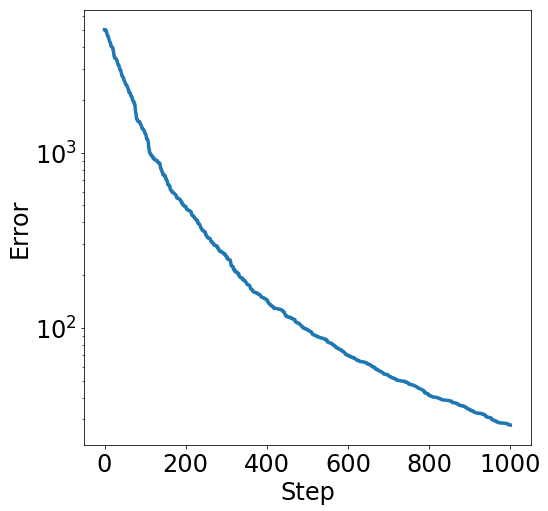

In [5]:
xs = random_search(least_squares, b, 1000, gss)
error_plot([least_squares(x) for x in xs])

<a name="nm"></a>

#### Nelder-Mead

Nelder and Mead proposed a more sophisticated variant of random search.


In [6]:
def nelder_mead(oracle, init, num_steps):
    """Nelder-Mead search algorithm."""
    iterates = [init]
    scipy.optimize.minimize(oracle, init,
                            callback=lambda x: iterates.append(x),
                            options={'maxiter':num_steps},
                            method='Nelder-Mead')
    return iterates

Let's try this out on a common non-convex test function.

In [7]:
def himmelblau(x):
    """Himmelblau's function."""
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 -7)**2

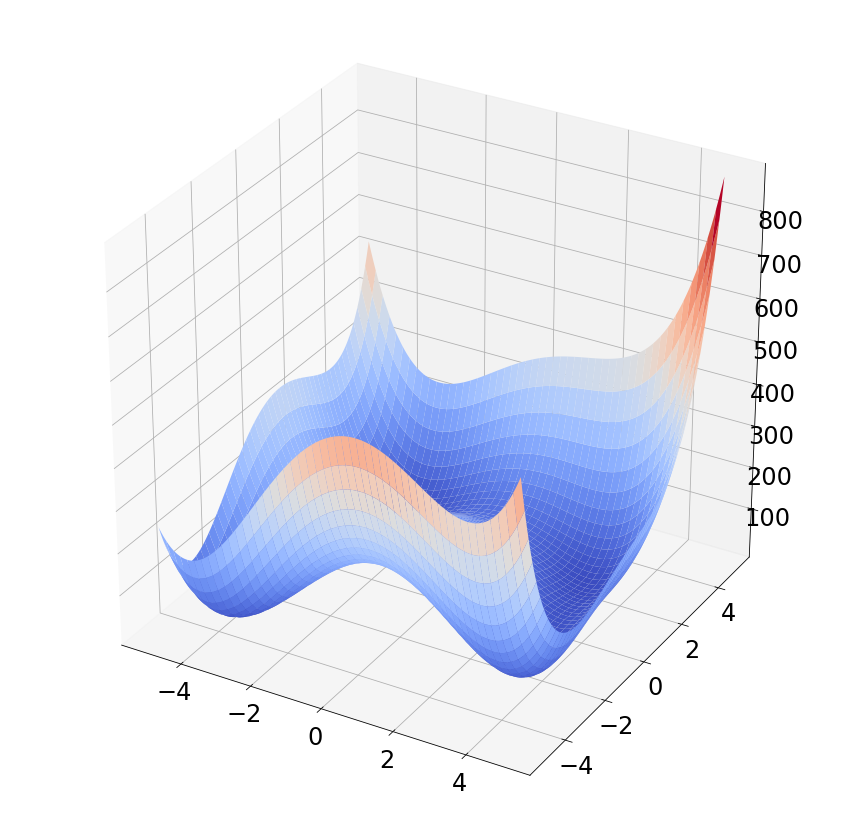

In [8]:
points = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(points, points)
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
_ = ax.plot_surface(X, Y, himmelblau([X, Y]), cmap=cm.coolwarm)

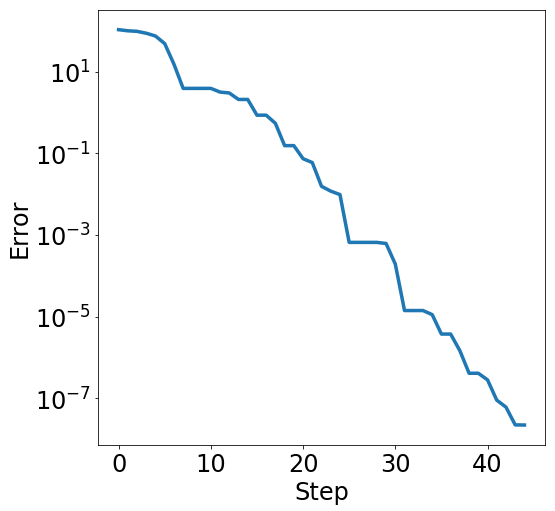

In [9]:
xs = nelder_mead(himmelblau, [1,1], 50)
error_plot([himmelblau(x) for x in xs])

Random search actually turns out to also do pretty well here.

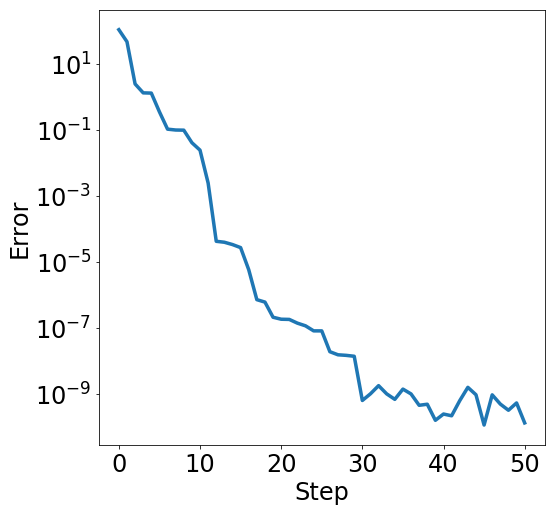

In [10]:
xs = random_search(himmelblau, np.array([1,1]), 50, gss)
error_plot([himmelblau(x) for x in xs])

<a name="rl"></a>

## Reinforcement learning in 20 minutes

Consider an abstract dynamical system model

$$
    x_{t+1} = f( x_t, u_t, e_t)\,.
$$

Here, $x_t$ is the _state_ of the system, $u_t$ is the control action, and $e_t$ is a random disturbance. We’re going to assume that $f$ is fixed, but unknown.

A _trajectory_ is a sequence of states and control actions generated by this dynamical system.

$$
\tau_t = (u_1,…,u_{t-1},x_0,…,x_t) \,.
$$

A _control policy_ (or simply “a policy”) is a function, $\pi$, that takes a trajectory from a dynamical system and outputs a new control action.  Note that $\pi$ only gets access to previous states and control actions.

For example, a common kind of policy arising in control theory maps the previous state to a control action via a linear map $K$:

$$
\pi(\tau_t) = K x_t
$$


<a name="flappy"></a>

### Flappy bird dynamical system

Imagine we have a little bird flying in the air at constant velocity. Its vertical position $h$ is governed by gravity and air resistance. So, the total downward force is $F = mg - kv,$ where $g$ is the acceleration due to gravity, $v$ is the downward velocity and $k$ is a drag coefficient that relates air resistance to velocity. Using $F=ma,$ this gives the first-order differential equation $\frac{dv}{dt}= g - kv.$

The bird can choose to accelerate upwards. It's trying to avoid hitting the ground $h=0,$ while minimizing the energy consumed for upward acceleration.

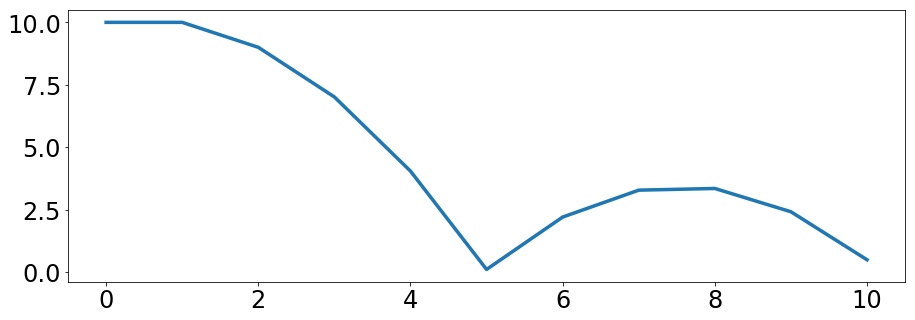

In [11]:
def flappy_bird(state, action):
    """Flappy bird dynamical system.
    
    state: pair of downward velocity and height
    action: upward acceleration
    
    Returns new state."""
    v, h = state
    g = 1. # acceleration due to gravity
    k = 0.01 # drag coefficient
    m = 1 # mass
    return (v + g - (k/m)*v - action, h - v)

def unroll(system, inits, policy, num_steps):
    """Unroll a dynamical system."""
    states = [inits[0]]
    actions = [inits[1]]
    for _ in range(num_steps):
        action = policy(states, actions)
        actions.append(action)
        states.append(system(states[-1], action))
    return states, actions

def example_policy(states, actions):
    """Accelerate upwards every 5 steps."""
    v, h = states[-1]
    if divmod(len(states), 5)[1] == 0:
        return 7
    else:
        return 0.

states, actions = unroll(flappy_bird, [(0, 10.), 0], example_policy, 10)
heights = [h for (v, h) in states]
plt.figure(figsize=(15,5))
plt.plot(range(len(heights)), heights, **kwargs)

Our policy looks good on a short horizon, but in the long term it goes way higher than it needs to.

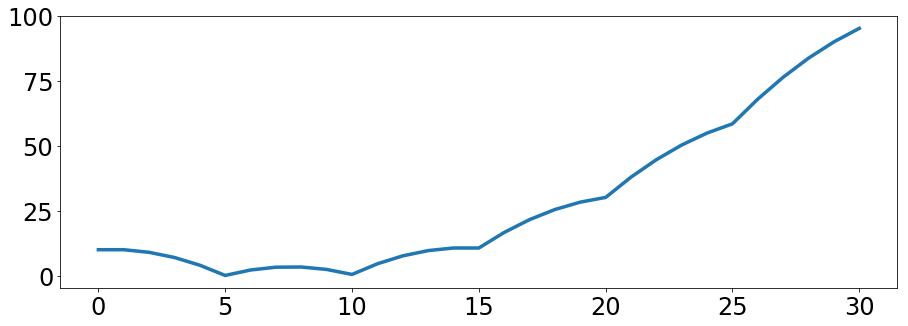

In [12]:
states, actions = unroll(flappy_bird, [(0, 10.), 0], example_policy, 30)
heights = [h for (v, h) in states]
plt.figure(figsize=(15,5))
plt.plot(range(len(heights)), heights, **kwargs)

At this point, we could either use physics (but that's too hard for me!) or try to learn a good policy!

<a name="learning"></a>

### Learning policies from rewards

The main goal in reinforcement learning is to solve the optimal control problem:

$$
\begin{array}{ll}
\mbox{maximize}_{u_t} & \mathbb{E}_{e_t}[ \sum_{t=0}^N R_t[x_t,u_t] ]\\
\mbox{subject to} &    x_{t+1} = f(x_t, u_t, e_t)\\
& \mbox{($x_0$ given)}
\end{array}
$$

* $R_t[x_t,u_t]$ is a *reward*, which we assume is known.
* The function $f$ is unknown.

In our flappy bird example, we'd get a huge negative reward for hitting the ground, and a small negative reward for accelerating upwards.

The main paradigm in contemporary RL is to play the following game. We decide on a policy $\pi$ and horizon length $L$. Then we either pass this policy to a simulation engine or to a real robotic system and are returned a trajectory

$$
\tau_L = (u_1,…,u_{L-1},x_0,…,x_L)\,,
$$

where $u_t = \pi(\tau_t)$. This is our _oracle model_. We typically want to minimize the total number of samples computed by the oracle. So if we were to run $m$ queries with horizon length $L$, we would pay a total cost of $mL$.  However, we are free to vary our horizon length for each experiment.

<a name="policy"></a>

### Policy gradient

In the policy gradient approach, we imagine that policies are randomized and specified be a set of parameters $\theta$ that we can tune.

We can then write the reward maximization problem as a general stochastic optimization problem of the form. Let $p_\theta$ denote the probability distribution over trajectories resulting from our the parameters $\theta.$ Below we use $\mathbb{E}_\theta$ to denote the expectation over trajectories drawn from $p_\theta$.

$$
	J(\theta):=\mathbb{E}_\theta[R(u)]
$$

The key idea is to compute the gradient of $J(\theta)$ using the following trick.

$$
\begin{align*}
	\nabla_{\theta} J(\theta) &= \int R(u) \nabla_{\theta} p_\theta(u) \,\mathrm{d}u\\
	&= \int R(u) \left(\frac{\nabla_{\theta} p_\theta(u)}{p_\theta(u)}\right) p_\theta(u) \,\mathrm{d}u\\
	&= \int \left( R(u) \nabla_{\theta} \log p_\theta(u) \right) p_\theta(u)\,\mathrm{d}u	\\
  &= \mathbb{E}_{\theta}\left[ R(u) \nabla_{\theta} \log p_\theta(u) \right]\,.
\end{align*}
$$

And hence the following is a general purpose algorithm for maximizing rewards with respect to parametric distributions:

Choose some initial guess $\theta_0$

**REINFORCE:**

Iterate for $t\ge 1:$

* Sample $u_k$ i.i.d., from $p_{\theta_k}$.
* Set $\theta_{k+1} = \theta_k + \alpha_k R(u_k) \nabla_{\theta} \log p_{\theta_k}(u_k)$, where $\alpha_k$ is some step size.

Note that the reward function we want to is only accessed through function evaluations. We **never compute gradients of $R$ itself**.
Therefore, this method is best thought of as a *zeroth-order optimization* algorithm akin to random search or Nelder-Mead.

*The original source of this section is [this blog post](http://www.argmin.net/2018/02/20/reinforce/). Check it out as it has additional details.*

### Solving flappy bird

Let's see how these ideas can get us a good policy for the flappy bird game.

In [13]:
def flappy_reward(state, action):
    v, h = state
    reward = 0.0
    if h < 0:
        reward += 10*h
    if action > 0:
        reward -= action
    return reward

def flappy_total_reward(states, actions):
    zips = zip(states, actions)
    return np.sum([flappy_reward(s, a) for (s,a) in zips])

def flappy_policy(theta, states, actions):
    """Linear map of last two states."""
    if len(states) == 1:
        states = states + states
    return np.dot(theta, np.reshape(np.array(states[-2:]), (4,)))

def flappy_objective(theta, num_steps):
    """Compute rewards of policy for given number of steps."""
    inits = [(0, 10.), 0]
    policy = lambda states, actions: flappy_policy(theta, states, actions)
    states, actions = unroll(flappy_bird, inits, policy, num_steps)
    return flappy_total_reward(states, actions)


Since we just convinced ourselves that policy gradient is essentially zero-order optimization, we might as well use our random search algorithm from before to find a good policy.

In [14]:
def objective(theta, horizon=20):
    return -1.0*flappy_objective(theta, horizon)

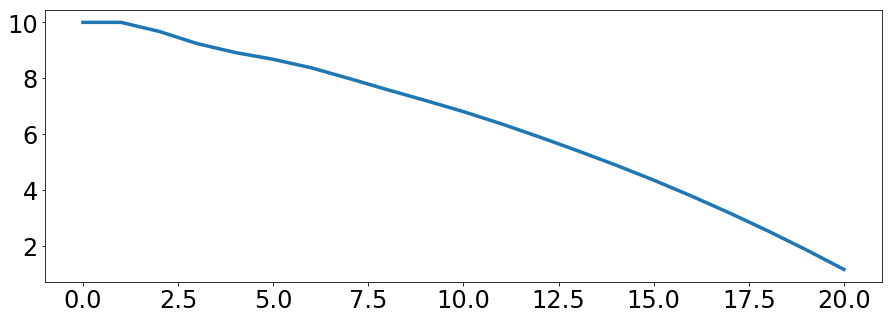

In [15]:
xs = random_search(objective, np.zeros(4), 10, gss)
policy = lambda states, actions: flappy_policy(xs[-1], states, actions)
states, actions = unroll(flappy_bird, [(0, 10.), 0], policy, 20)
heights = [h for (v, h) in states]
plt.figure(figsize=(15,5))
plt.plot(range(len(heights)), heights, **kwargs)

We see that the bird avoids ever hitting the ground on the horizon it was trained for, while minimizing the amount of upward acceleration necessary.

### Sample complexity considerations 

Let's discuss some sample complexity issues taken from [this blog post](http://www.argmin.net/2018/02/20/reinforce/) by Ben Recht.

Consider a simple objective that arises from the Least Quadratic Regulator (LQR) problem in control theory:

$$
	R(u) = -||u-z||^2
$$

Let $p_\theta$ be a multivariate Gaussian with mean $\theta$ and covariance matrix $\sigma^2 I$.  What does policy gradient do?  First, note that

$$
	J(\theta) = \mathbb{E}_{\theta} [R(u)]= -\|\theta-z\|^2 - \sigma^2 d
$$

As a function of $\theta$, $J$ is _strongly concave_, and the most important quantity to understand the convergence of policy gradient is   the expected norm of the gradient as this will control the number of iterations. Now, if you start at $\theta=0$, then the gradient is

$$
	g=\frac{||\omega-z||^2 \omega}{\sigma^2}\,,
$$

where $\omega$ is a normally distributed random vector with mean zero and covariance $\sigma^2 I$. If you grind through the details, you'll see the expected norm of this gradient is on the order of

$$
O\left(\sigma d^{1.5} + \sigma^{-1} d^{0.5} \|z\|\right)\,.
$$

That's quite large in the dimension of the problem. For a better way to solve LQR and other problems, check out [this post](http://www.argmin.net/2018/02/08/lqr/).

## That's it. Thanks.